In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import utils
slim = tf.contrib.slim
from utils import plot_boundaries


## Hyperparameters

In [6]:
params = dict(
    batch_size=256,
    unl_batch_size = 256,
    learning_rate=3e-4,
    beta1=0.5,
    epoch=2000,
    epsilon=1e-8,
    max_iter=16000,
    viz_every=500,
    z_dim=2,
    x_dim=2,
    optimizer='rmsprop', # rmsprop sgd sga
    seed = 122524,
    nabla = 0,
    reg_w = 10. 
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data Creation

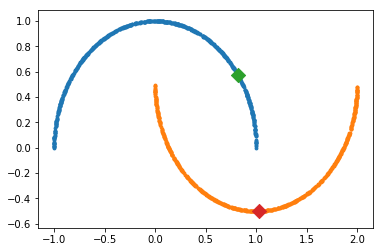

In [7]:
labeled =1
x,y=make_moons(n_samples=4000, shuffle=True, noise=0., random_state=rng.randint(2**10))
trainx, testx, trainy, testy = train_test_split(x, y, test_size=0.30, random_state=rng.randint(2**10))
trainx_unl = trainx.copy()

inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']

utils.scatter_2_class(testx,testy,s=8)
# utils.scatter_2_class(trainx_unl,np.ones(trainx_unl.shape[0]),s=1,c='k')
utils.scatter_2_class(trainx,trainy,marker = 'D',s=100)
plt.show()


In [8]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return tf.squeeze(log_d)

## Build model

In [9]:
tf.reset_default_graph()

In [10]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['unl_batch_size'])

train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params['batch_size'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params['batch_size'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
training_init_op = iterator.make_initializer(train_dataset)
validation_init_op = iterator.make_initializer(test_dataset)

iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

In [11]:
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

optimizer = tf.train.RMSPropOptimizer(params['learning_rate'])

d_grads = tf.gradients(loss, disc_vars)
g_grads = tf.gradients(-loss, gen_vars)

variables = disc_vars + gen_vars
grads = d_grads + g_grads
    
reg = 0.5 * sum(tf.reduce_sum(tf.square(g)) for g in grads)
Jgrads = tf.gradients(reg, variables)

apply_vec = [(g + params['reg_w'] * Jg, v)for (g, Jg, v) in zip(grads, Jgrads, variables) if Jg is not None]

global_step = tf.Variable(0, name='global_step',trainable=False)
with tf.control_dependencies([g for (g, v) in apply_vec]):
    train_op = optimizer.apply_gradients(apply_vec, global_step=global_step)    
        

## Vizualisation perturbation

In [12]:
perturb = tf.random_normal([params['batch_size'],params['z_dim']], mean=0, stddev=1)
perturb = tf.nn.l2_normalize(perturb, dim=[1])
z_pert = noise + 1e-4* perturb
samples_perturb = generator(z_pert, output_dim=params['x_dim'], reuse=True)

#to get ops on a loaded meta graph
samples_perturb = tf.identity(samples_perturb,name='sample_perturb')
samples = tf.identity(samples,name='samples')

## Train GAN

In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [14]:
saver = tf.train.Saver()

In [17]:
if tf.train.latest_checkpoint('./saved_models/gan_latent_2dim*') is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint('./saved_models/gan_latent_2dim*'))
else:
    print('no model found')

no model found
The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


global step: 5660


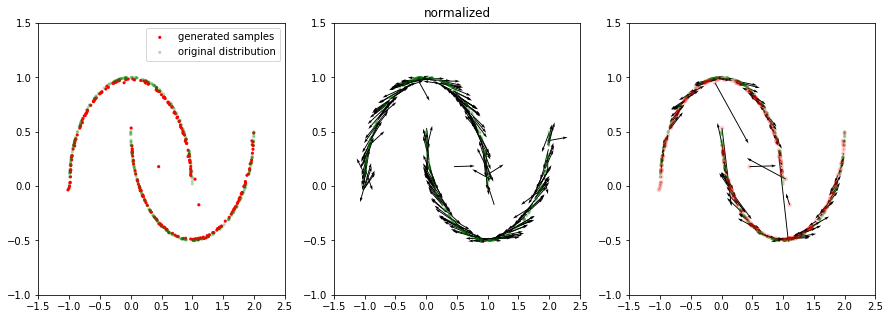

KeyboardInterrupt: 

In [17]:
fs = []
frames = []
np_samples = []
n_batches_viz = 1
viz_every = params['viz_every']
n_quiver = 8000

yy = np.vstack([sess.run(data) for _ in range(n_batches_viz)])

for i in tqdm(range(params['max_iter']+1)):
    f, _= sess.run([[loss], train_op])
    
    fs.append(f)
    if (i) % viz_every == 0:
        xx, zz = sess.run([samples,samples_perturb])      
        uu = zz - xx 
        norm = np.linalg.norm(uu,axis=1,keepdims=1)
        uu_n = uu / (norm * np.ones([1,2]))
        
        print("global step:", sess.run(global_step))
        fig = plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10,c='r')
        plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
#         plt.scatter(zz[:, 0], zz[:, 1], edgecolor='none',s=10,alpha = 0.3)
        plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
        plt.legend(['generated samples','original distribution'])

        plt.subplot(122)
        plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu_n[:n_quiver,0], uu_n[:n_quiver,1],scale = 12)
        plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
        plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
#         plt.legend(['normalized local perturabtion','samples original distrinbution'])
        plt.title('normalized')
        
#         plt.subplot(133)
#         plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
#         plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu[:n_quiver,0], uu[:n_quiver,1])
#         plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
#         plt.scatter(xx[:n_quiver, 0], xx[:n_quiver, 1], edgecolor='none',s=20,c='r',alpha = 0.2)
#         plt.scatter(zz[:n_quiver, 0], zz[:n_quiver, 1], edgecolor='none',s=20)
#         for i in range(n_quiver):
#             plt.arrow(xx[i,0], xx[i,1], uu[i,0], uu[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k',alpha=0.4,color='r')
        plt.savefig('destination_path.eps', format='eps', dpi=1000)
        plt.show()

In [17]:
# name = 'con_gan_000'
# save_path = os.path.join('./saved_models/',name)
saver.save(sess, './saved_models/gan_latent_2dim')

'./saved_models/gan_latent_2dim'

## Classifier

In [18]:
params_dnn = dict(
    epsilon = .01,
    gamma = 4., #2.
    batch = 200,
    mc_batch = 1000,
    lr=1e-5,
    beta1 = 0.9,
    epoch = 4000,
    l2_w = 0.1
)


In [19]:
def classifier(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None,weights_regularizer=slim.l2_regularizer(params_dnn['l2_w']))
    return tf.squeeze(log_d)

soft = lambda x: 1/(1+tf.exp(-x))

In [20]:
labeled_data = tf.cast(next_element,tf.float32)
lbl = tf.cast(next_label,tf.float32)

with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.2)):
        logits = classifier(labeled_data)
        
logits_gen = classifier(samples,reuse = True)
logits_gen_perturb = classifier(samples_perturb,reuse = True)

_nabla = tf.gradients(logits_gen, noise)[0]

z = tf.random_normal(shape=[params_dnn['mc_batch'],params['z_dim']])
perturb = tf.random_normal([params_dnn['mc_batch'],params['z_dim']], mean=0, stddev=1)
perturb_n = tf.nn.l2_normalize(perturb, dim=[1])
z_pert = z + params_dnn['epsilon']* perturb_n

samp = generator(z)
samp_adv = generator(z_pert)

samp_adv = samp + 0.20* tf.nn.l2_normalize(samp_adv-samp,dim=[1])

f_samp_adv = soft(classifier(samp_adv))
f_samp = soft(classifier(samp))


tan_consistency = tf.sqrt(1e-8 + tf.pow(f_samp_adv-f_samp,2))
tan_loss = tf.reduce_mean(tan_consistency)

xloss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=lbl)) 
_l2 = tf.losses.get_regularization_losses(scope='classifier')

loss = xloss + params_dnn['gamma'] * tan_loss + _l2

with tf.variable_scope('classifier', reuse = tf.AUTO_REUSE):
    with tf.variable_scope('optimizer', reuse = tf.AUTO_REUSE):
#         optimizer = tf.train.RMSPropOptimizer(params['learning_rate'])
        optimizer = tf.train.AdamOptimizer(params_dnn['lr'])
        train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'))
        
accuracy = utils.accuracy(logits,next_label)
prediction = utils.prediction(logits)

## dataset meshgrid vizualisation
x_pl = tf.placeholder(tf.float32,[None,2])
logits_pl = tf.squeeze(classifier(x_pl))
#init
var = tf.global_variables(scope='classifier')
init_op = tf.variables_initializer(var_list=var)

(-1, 1.5)

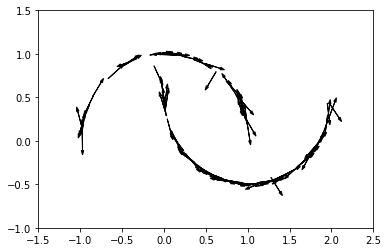

In [22]:
zz, xx, yy = sess.run([samp_adv, samp,data]) # _nabla = tf.gradients(logits_gen, noise)[0]
n_quiver = 100
uu = zz - xx 
for i in range(n_quiver):
    plt.arrow(xx[i,0], xx[i,1], uu[i,0], uu[i,1], head_width=0.03, head_length=0.05, fc='k', ec='k',alpha=1,color='r')
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])

In [23]:
xls=[]; jls =[]; reg = []
sess.run(init_op)
sess.run(training_init_op)
for step in tqdm(range(params_dnn['epoch']+1)):
    xl, _, train_acc, tan = sess.run([xloss, train_op, accuracy, tan_loss])
    xls.append(xl); jls.append(tan)

    if step % 300 == 0:
        sess.run(validation_init_op)
        test_acc = 0; pred = []; valid_iters = nr_batch_test;
        for i in range(valid_iters):
            acc,p = sess.run([accuracy,prediction])
            test_acc += acc; pred.append(p);
        pred = np.concatenate(pred); test_acc /= valid_iters
#         if step != 0:
#             plot_boundaries()
        print("Step: {}, xloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%".format(step, xl, acc * 100,test_acc))
        sess.run(training_init_op)

Step: 0, xloss: 0.69457, training acc: 54.69%, test acc: 0.60%
Step: 300, xloss: 0.35704, training acc: 83.59%, test acc: 0.85%
Step: 600, xloss: 0.06447, training acc: 88.67%, test acc: 0.89%
Step: 900, xloss: 0.02026, training acc: 84.38%, test acc: 0.86%
Step: 1200, xloss: 0.00948, training acc: 84.77%, test acc: 0.86%
Step: 1500, xloss: 0.00661, training acc: 86.33%, test acc: 0.88%
Step: 1800, xloss: 0.00372, training acc: 87.89%, test acc: 0.89%
Step: 2100, xloss: 0.00059, training acc: 100.00%, test acc: 1.00%


KeyboardInterrupt: 

In [24]:
x_min =-1.5; x_max = 2.5; y_min = -1; y_max = 1.5; h = 0.01;
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.vstack([xx.ravel(),yy.ravel()]).T

zz = sess.run(logits_pl,{x_pl:grid})
softmax = lambda x: 1/(1+np.exp(-x))
zz=softmax(zz)
_xx, mm = sess.run([samp,tan_consistency])

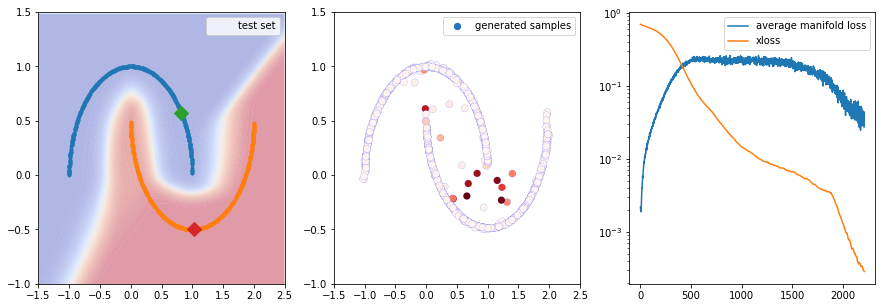

In [25]:
n_test = len(pred)
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
cnt = plt.contourf(xx, yy, zz.reshape(xx.shape),200,cmap=plt.cm.coolwarm, alpha=0.4)
# plt.contour(xx, yy, zz.reshape(xx.shape),1,map=plt.cm.binary, alpha=0.5,linewidths=2,linestyles='solid')
utils.scatter_2_class(testx[:n_test],pred,s=8)
utils.scatter_2_class(trainx,trainy, marker='D',s=100)
plt.legend(['test set'])

plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])

# This is the fix for the white lines between contour levels
for c in cnt.collections:
    c.set_edgecolor("Face")
    c.set_linewidth(1e-9)

plt.subplot(132)
plt.scatter(_xx[:,0],_xx[:,1], s=50, alpha=1.,c=mm,cmap='Reds',norm=None,linewidths=0.1,edgecolors='b')
plt.legend(['generated samples'])
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])


plt.subplot(133)
plt.semilogy([j*params_dnn['gamma'] for j in jls])
plt.semilogy(xls)
plt.legend(['average manifold loss','xloss'])
plt.show()    

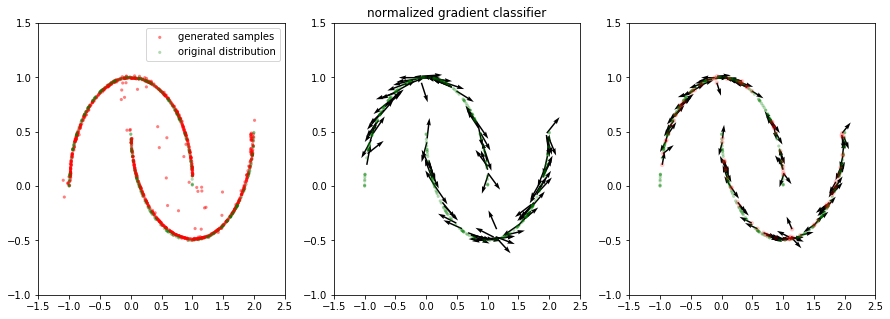

In [26]:
zz, xx, yy = sess.run([samp_adv, samp,data]) # _nabla = tf.gradients(logits_gen, noise)[0]
uu = zz - xx 
norm = np.linalg.norm(uu,axis=1,keepdims=1)
uu_n = uu / (norm * np.ones([1,2]))
n_quiver = 100
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10,c='r',alpha=0.5)
plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
#         plt.scatter(zz[:, 0], zz[:, 1], edgecolor='none',s=10,alpha = 0.3)
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
plt.legend(['generated samples','original distribution'])

plt.subplot(132)
plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu_n[:n_quiver,0], uu_n[:n_quiver,1],scale = 12)
plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
#         plt.legend(['normalized local perturabtion','samples original distrinbution'])
plt.title('normalized gradient classifier')

plt.subplot(133)
plt.xlim([-1.5,2.5]);plt.ylim([-1,1.5])
plt.quiver(xx[:n_quiver, 0], xx[:n_quiver, 1],  uu[:n_quiver,0], uu[:n_quiver,1])
plt.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10,alpha = 0.3)
plt.scatter(xx[:n_quiver, 0], xx[:n_quiver, 1], edgecolor='none',s=20,c='r',alpha = 0.2)
plt.show()